In [1]:
import re
import nltk

import pandas as pd
import numpy as np
import random
import itertools

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer = nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def review_to_wordlist( review, remove_stopwords=True):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review)
    words = review_text.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    b=[]
    stemmer = english_stemmer
    for word in words:
        b.append(stemmer.stem(word))
        
    return(b)

In [3]:
data_file = 'Amazon_Unlocked_Mobile.csv'

n = 413000  
s = 20000 
skip = sorted(random.sample(range(1,n), n-s))

data = pd.read_csv( data_file, delimiter = ",", skiprows = skip)

In [4]:
data.shape

(20840, 6)

In [5]:
data = data[data['Reviews'].isnull()==False]

In [6]:
train, test = train_test_split(data, test_size = 0.3)

<AxesSubplot:xlabel='Rating', ylabel='count'>

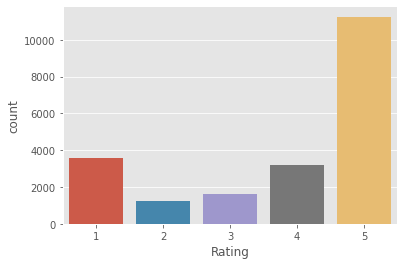

In [7]:
sns.countplot(x=data['Rating'])

In [8]:
clean_train_reviews = []
for review in train['Reviews']:
    clean_train_reviews.append( " ".join(review_to_wordlist(review)))
    
clean_test_reviews = []
for review in test['Reviews']:
    clean_test_reviews.append( " ".join(review_to_wordlist(review)))

C:\Users\mohdm\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\mohdm\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [9]:
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 200000, ngram_range = ( 1, 4 ), sublinear_tf = True )
vectorizer = vectorizer.fit(clean_train_reviews)

train_features = vectorizer.transform(clean_train_reviews)
test_features = vectorizer.transform(clean_test_reviews)

In [10]:
fselect = SelectKBest(chi2 , k=10000)
train_features = fselect.fit_transform(train_features, train["Rating"])
test_features = fselect.transform(test_features)

In [11]:
model1 = MultinomialNB(alpha=0.001)
model1.fit( train_features, train["Rating"])

model2 = SGDClassifier(loss='modified_huber', random_state=0, shuffle=True)
model2.fit( train_features, train["Rating"])

model3 = RandomForestClassifier()
model3.fit( train_features, train["Rating"])

model4 = GradientBoostingClassifier()
model4.fit( train_features, train["Rating"])

pred_1 = model1.predict( test_features.toarray())
pred_2 = model2.predict( test_features.toarray())
pred_3 = model3.predict( test_features.toarray())
pred_4 = model4.predict( test_features.toarray())

In [12]:
print("Multinomial Naive Bayes")
print(classification_report(test['Rating'], pred_1, target_names=['1', '2', '3', '4', '5']))

Multinomial Naive Bayes
              precision    recall  f1-score   support

           1       0.64      0.69      0.66      1075
           2       0.51      0.12      0.20       368
           3       0.43      0.15      0.22       514
           4       0.37      0.17      0.23       964
           5       0.70      0.92      0.79      3331

    accuracy                           0.65      6252
   macro avg       0.53      0.41      0.42      6252
weighted avg       0.60      0.65      0.60      6252



In [13]:
print("Stochastic Gradient Descent")
print(classification_report(test['Rating'], pred_2, target_names=['1', '2', '3', '4', '5']))

Stochastic Gradient Descent
              precision    recall  f1-score   support

           1       0.65      0.77      0.71      1075
           2       0.47      0.10      0.17       368
           3       0.55      0.15      0.23       514
           4       0.39      0.17      0.24       964
           5       0.72      0.94      0.81      3331

    accuracy                           0.68      6252
   macro avg       0.56      0.43      0.43      6252
weighted avg       0.63      0.68      0.62      6252



In [14]:
print("Random Forest")
print(classification_report(test['Rating'], pred_3, target_names=['1', '2', '3', '4', '5']))

Random Forest
              precision    recall  f1-score   support

           1       0.64      0.76      0.69      1075
           2       0.81      0.09      0.17       368
           3       0.80      0.12      0.21       514
           4       0.59      0.12      0.20       964
           5       0.69      0.96      0.80      3331

    accuracy                           0.68      6252
   macro avg       0.70      0.41      0.41      6252
weighted avg       0.68      0.68      0.60      6252



In [15]:
print("Gradient Boosting")
print(classification_report(test['Rating'], pred_4, target_names=['1', '2', '3', '4', '5']))

Gradient Boosting
              precision    recall  f1-score   support

           1       0.65      0.55      0.60      1075
           2       0.31      0.03      0.05       368
           3       0.43      0.04      0.08       514
           4       0.43      0.10      0.17       964
           5       0.64      0.97      0.77      3331

    accuracy                           0.63      6252
   macro avg       0.49      0.34      0.33      6252
weighted avg       0.57      0.63      0.55      6252



In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


C:\Users\mohdm\AppData\Local\Temp\ipykernel_12940\2695842966.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


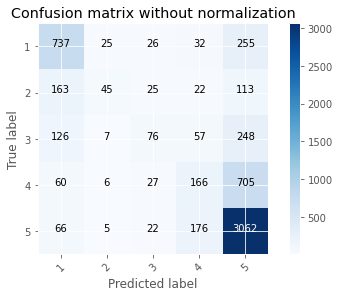

In [17]:
mnb_matrix = confusion_matrix(test['Rating'], pred_1)
plot_confusion_matrix(mnb_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix without normalization')

Confusion matrix, without normalization


C:\Users\mohdm\AppData\Local\Temp\ipykernel_12940\2695842966.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


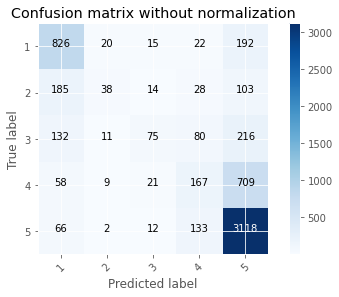

In [18]:
sgd_matrix = confusion_matrix(test['Rating'], pred_2)
plot_confusion_matrix(sgd_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix without normalization')

Confusion matrix, without normalization


C:\Users\mohdm\AppData\Local\Temp\ipykernel_12940\2695842966.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


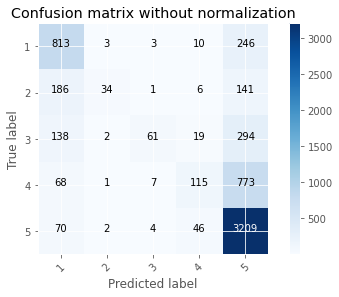

In [19]:
rf_matrix = confusion_matrix(test['Rating'], pred_3)
plot_confusion_matrix(rf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix without normalization')

C:\Users\mohdm\AppData\Local\Temp\ipykernel_12940\2695842966.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization


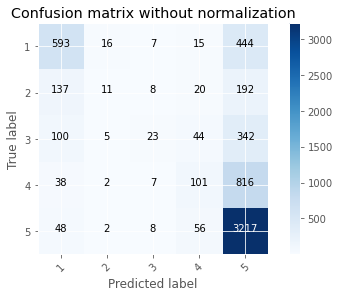

In [20]:
gb_matrix = confusion_matrix(test['Rating'], pred_4)
plot_confusion_matrix(gb_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix without normalization')

In [21]:
print('Multinomial Naive Bayes accuracy: ', accuracy_score(test['Rating'], pred_1))
print('Stochastic Accuracy accuracy: ', accuracy_score(test['Rating'], pred_2))
print('Random Forest Classifier accuracy: ', accuracy_score(test['Rating'], pred_3))
print('Gradient Boosting accuracy: ', accuracy_score(test['Rating'], pred_4))

Multinomial Naive Bayes accuracy:  0.6535508637236085
Stochastic Accuracy accuracy:  0.6756238003838771
Random Forest Classifier accuracy:  0.6769033909149073
Gradient Boosting accuracy:  0.6309980806142035


In [22]:
batch_size = 32
nb_classes = 5

In [23]:
vectorizer = TfidfVectorizer( min_df=2, max_df=0.95, max_features = 1000, ngram_range = ( 1, 3 ), sublinear_tf = True )
vectorizer = vectorizer.fit(clean_train_reviews)

train_features = vectorizer.transform(clean_train_reviews)
test_features = vectorizer.transform(clean_test_reviews)

In [24]:
X_train = train_features.toarray()
X_test = test_features.toarray()

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(train['Rating']-1)
y_test = np.array(test['Rating']-1)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


# pre-processing: divide by max and substract mean
scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.mean(X_train)
X_train -= mean
X_test -= mean

input_dim = X_train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(256, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print("Training...")
model.fit(X_train, Y_train, epochs=5, batch_size=16, validation_split=0.1)

print("Generating test predictions...")
pred_5 = model.predict(X_test, verbose=0)

loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print("Deep Dumb MLP Accuracy: ", format(accuracy))

X_train shape: (14585, 1000)
X_test shape: (6252, 1000)
Training...
Epoch 1/5
821/821 [==============================] - 2s 2ms/step - loss: 0.9748 - accuracy: 0.6384 - val_loss: 0.9057 - val_accuracy: 0.6532
Epoch 2/5
821/821 [==============================] - 2s 2ms/step - loss: 0.8481 - accuracy: 0.6873 - val_loss: 0.8727 - val_accuracy: 0.6854
Epoch 3/5
821/821 [==============================] - 2s 2ms/step - loss: 0.8145 - accuracy: 0.7037 - val_loss: 0.8687 - val_accuracy: 0.6779
Epoch 4/5
821/821 [==============================] - 2s 2ms/step - loss: 0.7839 - accuracy: 0.7171 - val_loss: 0.8987 - val_accuracy: 0.6785
Epoch 5/5
821/821 [==============================] - 2s 2ms/step - loss: 0.7571 - accuracy: 0.7278 - val_loss: 0.9322 - val_accuracy: 0.6813
Generating test predictions...
Deep Dumb MLP Accuracy:  0.6713051795959473
